Feature Engineering and Model Training

Going to make use a recurrent neurel network called LSTM (Long short term memory) for modelling stock price data as the data is sequential. As stock price data is sequential, where each data point depends on the previous ones. RNNs are designed to capture temporal dependencies, making them well-suited for modeling and predicting time series data.

Going to use the stock market prediction using LSTM recurrent neural network paper by Adil Moghar and Mhamed Hamiche as reference (https://www.sciencedirect.com/science/article/pii/S1877050920304865) to make my own model.

In [35]:
# Data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data processing
from sklearn.preprocessing import MinMaxScaler

# Model and measure metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

#Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

import yfinance as yf
import datetime

Going to create a model for the google stock price dataset, for reasons in inital analysis

In [36]:
def get_data(ticker, start, end):
    data =  yf.download(ticker, progress=True, actions=True,start=start, end=end)
    data = pd.DataFrame(data)
    data.drop(['Close', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
    data.rename(columns = {'Adj Close':"Close"}, inplace=True)
    data.dropna(inplace=True)
    
    return data

In [37]:
ticker = "GOOG"

In [38]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2022, 12, 31)

traindf = get_data(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


From 2023 onwards was chosen as test set as not including any of the downward trend would mean the model would not be perfrom well on unseen downward trend data.

In [39]:
start_test = datetime.datetime(2023, 1, 1)
end_test = datetime.datetime(2023, 12, 31)

testdf = get_data(ticker, start_test, end_test)

[*********************100%%**********************]  1 of 1 completed


Save index dates as keras requires numpy array not pandas dataframe

In [40]:
train_dates = traindf.index
test_dates = testdf.index

Closing price was chosen as returns possibly contain noise, needs further investigating: Future work!

Keras expects a 2d array where row i is input i and column j is feature j. only one feature so reshape(-1, 1) reshapes into a 2d array with 1 element in each row

In [41]:
train = np.array(traindf.Close)
test = np.array(testdf.Close)

train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [42]:
train

array([[39.30699921],
       [39.34500122],
       [39.70100021],
       ...,
       [86.45999908],
       [88.94999695],
       [88.73000336]])

Scaled with min-max scaler to normalize the data to a value between 0 and 1 for faster convergence and better performance.

In [43]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

Similar ACF plot to original Closing price before scaling. Shows min-max scaler did not effect the lagged values correlations.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

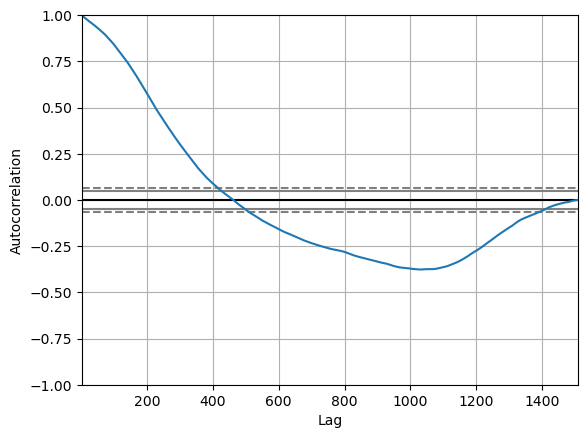

In [44]:
pd.plotting.autocorrelation_plot(train_scaled)

Note first 3 values in train_scaled very close or are 0. This is because earlier prices are far smaller than later prices and thus outliers are scaled close to 0 with a minmax scaler, rendering the earlier data more useless, this could be a problem or it could help training focus less on earlier data which could be good, needs further investigating.

In [45]:
train_scaled

array([[0.00000000e+00],
       [3.41125061e-04],
       [3.53674984e-03],
       ...,
       [4.23268879e-01],
       [4.45620344e-01],
       [4.43645572e-01]])

In [46]:
len(train), len(test)

(1510, 250)

Need to convert the data into supervised format for neural network. So data needs to be in (x,y) format where x are the features and y is the target. As time series data is sequential the features x are the number of previous days prices we use to predict next days price.

Going to use past 32 days as features as look back so, x(t-32), x(t-31), ... , x(t-1) will give x(t) which is y(t) 

In [47]:
look_back = 32
num_features = 1

In [48]:
train_scaled

array([[0.00000000e+00],
       [3.41125061e-04],
       [3.53674984e-03],
       ...,
       [4.23268879e-01],
       [4.45620344e-01],
       [4.43645572e-01]])

In [49]:
def shape_input(dataset,step):
    X = []
    Y = []
    for i in range(step, len(dataset)):
        X.append(dataset[i-step:i, 0])
        Y.append(dataset[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], num_features))

    return X, Y

In [50]:
X_train, y_train = shape_input(train_scaled,look_back)
X_test, y_test = shape_input(test_scaled, look_back)

In [51]:
X_train

array([[[0.00000000e+00],
        [3.41125061e-04],
        [3.53674984e-03],
        ...,
        [1.53991838e-02],
        [1.47394311e-02],
        [1.70643343e-02]],

       [[3.41125061e-04],
        [3.53674984e-03],
        [8.98098527e-03],
        ...,
        [1.47394311e-02],
        [1.70643343e-02],
        [1.88192347e-02]],

       [[3.53674984e-03],
        [8.98098527e-03],
        [9.20541146e-03],
        ...,
        [1.70643343e-02],
        [1.88192347e-02],
        [2.04305216e-02]],

       ...,

       [[4.92477682e-01],
        [5.15457567e-01],
        [5.09173977e-01],
        ...,
        [4.39426606e-01],
        [4.53340139e-01],
        [4.36464345e-01]],

       [[5.15457567e-01],
        [5.09173977e-01],
        [5.33320782e-01],
        ...,
        [4.53340139e-01],
        [4.36464345e-01],
        [4.23268879e-01]],

       [[5.09173977e-01],
        [5.33320782e-01],
        [5.35744407e-01],
        ...,
        [4.36464345e-01],
        [4.2326

Use keras sequential to build a custom model layer by layer. First LSTM layer needs an input to be the shape of the training input (which is the (x,y) format described above). 100 LSTM cells was decided after 50 showed no overfitting

In [52]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True, batch_input_shape=(32,look_back, num_features)))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
impl = model.fit(
    X_train,
    y_train,
    validation_split=0.33,
    epochs=100,
    )

Epoch 1/100


31/31 [==============================] - 6s 65ms/step - loss: 0.0049 - val_loss: 0.0200
Epoch 2/100
31/31 [==============================] - 1s 42ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 3/100
31/31 [==============================] - 1s 43ms/step - loss: 8.6432e-04 - val_loss: 0.0041
Epoch 4/100
31/31 [==============================] - 1s 44ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 8.3945e-04 - val_loss: 0.0076
Epoch 6/100
31/31 [==============================] - 2s 52ms/step - loss: 7.0630e-04 - val_loss: 0.0023
Epoch 7/100
31/31 [==============================] - 1s 46ms/step - loss: 7.3969e-04 - val_loss: 0.0063
Epoch 8/100
31/31 [==============================] - 1s 43ms/step - loss: 8.7849e-04 - val_loss: 0.0037
Epoch 9/100
31/31 [==============================] - 1s 48ms/step - loss: 6.3970e-04 - val_loss: 0.0021
Epoch 10/100
31/31 [==============================] - 1s 45ms/step - loss: 6.3875e-04 - 

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (32, 32, 100)             40800     
                                                                 
 dropout_4 (Dropout)         (32, 32, 100)             0         
                                                                 
 lstm_5 (LSTM)               (32, 32, 100)             80400     
                                                                 
 dropout_5 (Dropout)         (32, 32, 100)             0         
                                                                 
 lstm_6 (LSTM)               (32, 32, 100)             80400     
                                                                 
 dropout_6 (Dropout)         (32, 32, 100)             0         
                                                                 
 lstm_7 (LSTM)               (32, 100)                

Plot the training and validation loss to make sure overfitting does not occur and data is only trained on general principles.

Can see validation loss never trends up, so model is never trained too close to the training set.

In [54]:
impl.history.keys()

dict_keys(['loss', 'val_loss'])

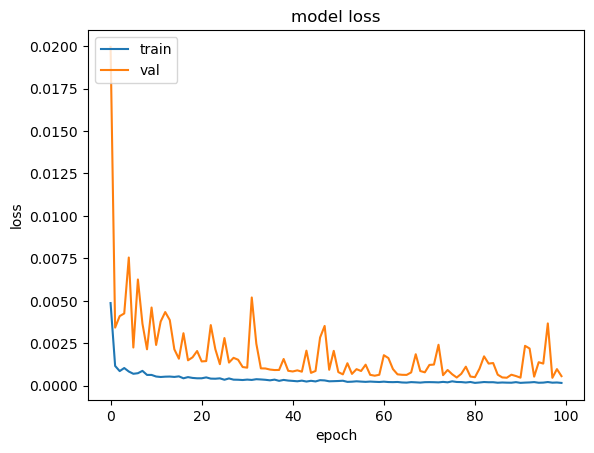

In [55]:
plt.plot(impl.history['loss'])
plt.plot(impl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
np.array(train[len(train)-look_back:]).shape

(32, 1)

In [57]:
np.array(test).shape

(250, 1)

In [58]:
predictions_scaled = model.predict(X_test)
predictions = sc.inverse_transform(predictions_scaled)

train = pd.DataFrame(train, index=train_dates)
test = pd.DataFrame(test, index=test_dates)
predictions = pd.DataFrame(predictions, index=test_dates[look_back:])

rmse = np.sqrt(np.mean(((predictions - test[look_back:]) ** 2)))
rmse

7/7 [==============================] - 1s 11ms/step


2.3037749294304493

Looks good but really only proves it can guess the next day well. Each sequence in X_test is the previous look_back number of days. If we want the model to guess further into the future we would have to use the models own previous predictions as if they were the real days. Or possibly a better alternative to predict further into the future would be a multi-step lstm. In a multistep lstm the X data would look like X = [x1, x2, ... , xlookback] and the Y data, Y = [y1, y2, ... , ypredictnum], where predictnum is the number of days we want to predict.

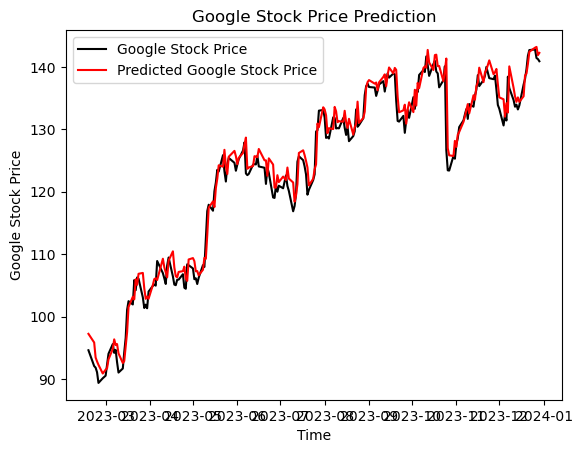

In [59]:
figure, axes = plt.subplots( 1 ) 

axes.plot(test[look_back:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

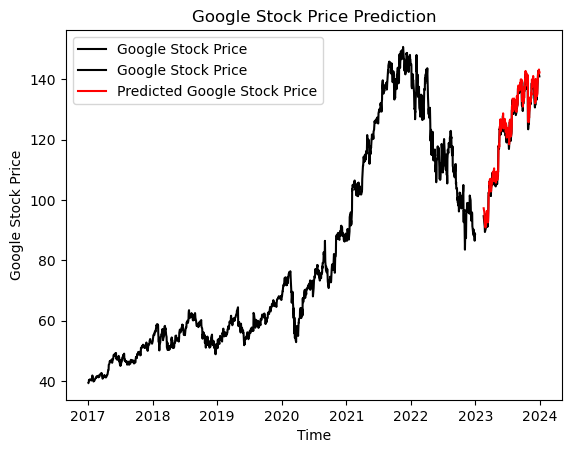

In [60]:
figure, axes = plt.subplots( 1 ) 

axes.plot(train, color = 'black', label = 'Google Stock Price')
axes.plot(test[look_back:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

In [61]:
predictions

,0
Date,
2023-02-17,97.219772
2023-02-21,95.830704
2023-02-22,93.430756
2023-02-23,92.797302
2023-02-24,92.250252
...,...
2023-12-22,142.446213
2023-12-26,143.103973
2023-12-27,143.225571


In [62]:
X_test

array([[[0.45235272],
        [0.443466  ],
        [0.42605157],
        ...,
        [0.49947934],
        [0.51877883],
        [0.50692985]],

       [[0.443466  ],
        [0.42605157],
        [0.43852897],
        ...,
        [0.51877883],
        [0.50692985],
        [0.4962478 ]],

       [[0.42605157],
        [0.43852897],
        [0.44427392],
        ...,
        [0.50692985],
        [0.4962478 ],
        [0.47344755]],

       ...,

       [[0.82927598],
        [0.85055024],
        [0.84678013],
        ...,
        [0.9200284 ],
        [0.92828676],
        [0.92918446]],

       [[0.85055024],
        [0.84678013],
        [0.862848  ],
        ...,
        [0.92828676],
        [0.92918446],
        [0.91679685]],

       [[0.84678013],
        [0.862848  ],
        [0.87137579],
        ...,
        [0.92918446],
        [0.91679685],
        [0.91536058]]])

In [63]:
testdf

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-03,89.830002,91.550003,89.019997,89.699997,20738500
2023-01-04,91.010002,91.239998,87.800003,88.709999,27046500
2023-01-05,88.070000,88.209999,86.559998,86.769997,23136100
2023-01-06,87.360001,88.470001,85.570000,88.160004,26612600
2023-01-09,89.195000,90.830002,88.580002,88.800003,22996700
...,...,...,...,...,...
2023-12-22,142.130005,143.250000,142.054993,142.720001,18494700
2023-12-26,142.979996,143.945007,142.500000,142.820007,11170100
2023-12-27,142.830002,143.320007,141.050995,141.440002,17288400


Predicting multiple days based on previous predictions:

In [64]:
test_lookback = X_test[0:1]
for i in range(0,250):
    test_lookback = np.append(test_lookback,model.predict(test_lookback))
    test_lookback = np.reshape(test_lookback, (1,len(test_lookback),1))
    print(model.predict(test_lookback))


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 835ms/step
[[0.5268998]]
1/1 [==============================] - 0s 14ms/step
[[0.5334709]]
1/1 [==============================] - 0s 14ms/step
[[0.53997344]]
1/1 [==============================] - 0s 14ms/step
[[0.54663473]]
1/1 [==============================] - 0s 16ms/step
[[0.55373025]]
1/1 [==============================] - 0s 13ms/step
[[0.56141347]]
1/1 [==============================] - 0s 13ms/step
[[0.56969607]]
1/1 [==============================] - 0s 17ms/step
[[0.57848185]]
1/1 [==============================] - 0s 13ms/step
[[0.5876188]]
1/1 [==============================] - 0s 13ms/step
[[0.596947]]
1/1 [==============================] - 0s 13ms/step
[[0.6063295]]
1/1 [==============================] - 0s 13ms/step
[[0.615669]]
1/1 [==============================] - 0s 13ms/step
[[0.62490684]]
1/1 [==============================] - 0s 13ms/step
[[0.6340154]]
1/1 [==============================] - 0s 13ms/step
[[0.64298683]]
1/1

In [65]:
test_lookback

array([[[0.45235272],
        [0.443466  ],
        [0.42605157],
        [0.43852897],
        [0.44427392],
        [0.44822354],
        [0.4753326 ],
        [0.47219084],
        [0.48017992],
        [0.47443497],
        [0.47102385],
        [0.49014384],
        [0.5383476 ],
        [0.55567225],
        [0.53771925],
        [0.51545757],
        [0.53727046],
        [0.551184  ],
        [0.52640884],
        [0.54364377],
        [0.55764709],
        [0.62380391],
        [0.59166803],
        [0.57595915],
        [0.61698175],
        [0.54481069],
        [0.50405737],
        [0.49867149],
        [0.49992819],
        [0.49947934],
        [0.51877883],
        [0.50692985],
        [0.51985395],
        [0.52689981],
        [0.53347093],
        [0.53997344],
        [0.54663473],
        [0.55373025],
        [0.56141347],
        [0.56969607],
        [0.57848185],
        [0.58761883],
        [0.59694701],
        [0.6063295 ],
        [0.61566901],
        [0

In [66]:
test_lookback = sc.inverse_transform(test_lookback[0])
test_lookback = test_lookback.reshape(-1) 
test_lookback = pd.DataFrame(test_lookback[look_back:], index=test_dates)

In [67]:
test_lookback

,0
Date,
2023-01-03,97.219769
2023-01-04,98.004693
2023-01-05,98.736728
2023-01-06,99.461120
2023-01-09,100.203202
...,...
2023-12-22,163.396141
2023-12-26,163.396699
2023-12-27,163.397230


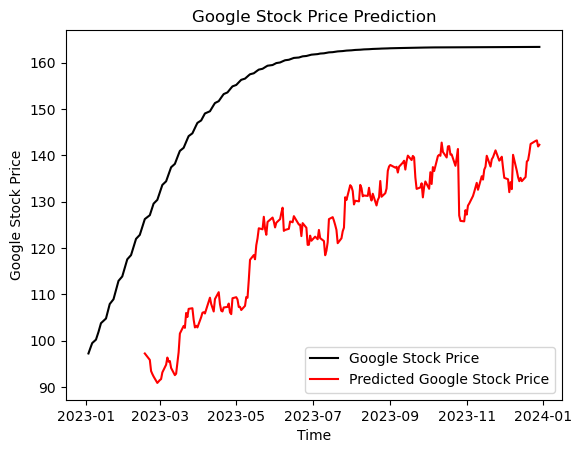

In [68]:
figure, axes = plt.subplots( 1 ) 

axes.plot(test_lookback, color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()